Introduction

AR (Autoregressive) dan MA (Moving Average) adalah dua jenis model dasar dalam analisis deret waktu "time series analysis".

AR (Autoregressive): Menggunakan nilai masa lalu (lagged values) dari seri itu sendiri untuk memprediksi nilai saat ini.
- AR → cocok untuk tren atau momentum jangka panjang.

MA (Moving Average): Menggunakan nilai error (residual) dari prediksi sebelumnya untuk memodelkan nilai sekarang.
- MA → cocok untuk menangkap dampak “kejutan” atau outlier yang bersifat sementara.

Contoh:
- AR: "Harga beras besok dipengaruhi harga hari ini."
- MA: "Harga beras hari ini dipengaruhi selisih prediksi kemarin yang salah."

Model Kombinasi (Advanced):
- ARMA(p, q) menggabungkan kedua komponen.
- ARIMA menambahkan diferensiasi (I) agar data stasioner.
- SARIMA juga memasukkan komponen musiman "Seasonal" (S).

p: jumlah lag dari nilai masa lalu yang digunakan sebagai variabel input (AR)

d: berapa kali data harus di-diferensiasi agar stasioner (I)

q: jumlah lag dari error yang digunakan dalam model (MA)

Pemilihan Parameter
- Tes stasionaritas (ADF test) → tentukan d
- Plot ACF/PACF untuk menemukan nilai p dan q
- Evaluasi model dengan AIC/BIC atau grid search

Load & Visualisasi Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/drive/MyDrive/il_du_revenue.csv', parse_dates=['date'], index_col='date')

/tmp/ipython-input-2-1311053516.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('/content/drive/MyDrive/il_du_revenue.csv', parse_dates=['date'], index_col='date')


In [3]:
df.head()

,revenue
date,
2023-01-01,"1,335,195,000"
2023-02-01,"1,179,731,000"
2023-03-01,"1,421,541,000"
2023-04-01,"1,398,688,000"
2023-05-01,"1,507,807,000"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27 entries, 2023-01-01 to 2025-03-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   revenue  27 non-null     object
dtypes: object(1)
memory usage: 432.0+ bytes


In [5]:
# Hapus karakter non-digit di kolom revenue dan ubah ke float
df['revenue'] = (
    df['revenue']
    .astype(str)
    .str.replace(r'[^\d\.]', '', regex=True)  # buang semua kecuali angka dan titik
    .replace('', '0')                         # kosong jadi 0
    .astype(float)
)

In [6]:
# Cek tipe data
print(df.dtypes)
# revenue    float64
# dtype: object

revenue    float64
dtype: object


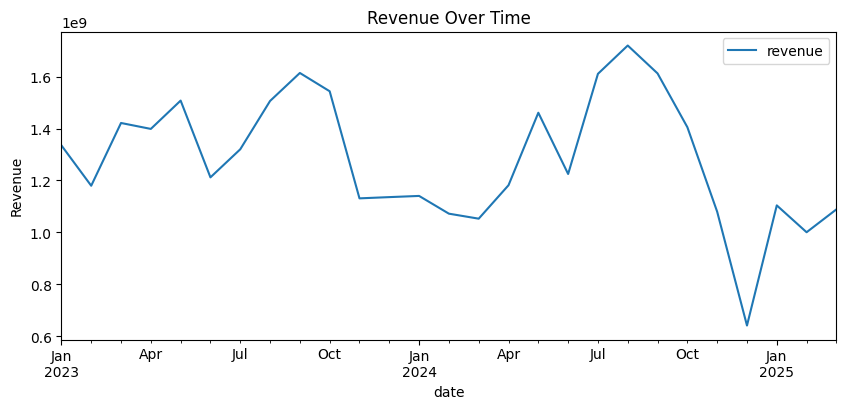

In [7]:
# Plot time series
df.plot(figsize=(10,4), ylabel='Revenue', title='Revenue Over Time')
plt.show()

Cek Stasionaritas

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
result = adfuller(df['revenue'])
print('p-value =', result[1])

p-value = 0.029495962121483303


Interpretasi p-value
- p-value < α (biasanya α = 0.05): tolak H₀ → data stasioner.
- p-value ≥ α: gagal tolak H₀ → data non-stasioner.



Jika Data Tidak Stasioner (Jalankan Kode berikut, hapus "#")

In [10]:
# Solusi 1: Differencing (Menghilangkan Tren)

# First Difference
# df['diff1'] = df['revenue'] - df['revenue'].shift(1)

# Cek ulang stasionaritas pada df['diff1'] dengan ADF test.

# Jika masih non-stasioner, ulangi (second difference):
# df['diff2'] = df['diff1'] - df['diff1'].shift(1)

# Catatan: Biasanya satu kali differencing "first difference" (d=1) sudah cukup untuk menghilangkan tren linear. Rekomendasi maks dua kali differencing, karena lebih dari itu jumlah data akan berkurang signifikan

# Solusi 2: Seasonal Difference
# Jika terdapat efek Seasonal "Musiman", maka keluarkan data tersebut dari analisis
# atau bisa lakukan Seasonal Differencing, tetapi ini akan menghilangkan banyak data, jangan lakukan jika data Anda sedikit n < 30.
# df['diff_seasonal'] = df['revenue'] - df['revenue'].shift(12)


# Solusi 3: Transformasi Variansi (Menhilangkan Heteroskedastisitas)
# Beberapa data menunjukkan variansi yang berubah-ubah (heteroskedastisitas).
# Untuk menstabilkannya, gunakan:

# Log transformation
# df['log_revenue'] = np.log(df['revenue'])


# Solusi 4: Detrending (Menghapus Tren dengan Regresi)
# Jika tren tidak linier, kamu bisa:
# Fit model regresi sederhana (misalnya polinomial) dan Kurangkan hasil prediksi tren dari nilai asli:
# trend = np.poly1d(np.polyfit(np.arange(len(df)), df['revenue'], deg=2))
# df['detrended'] = df['revenue'] - trend(np.arange(len(df)))


Tentukan Parameter Model
- Buat ACF/PACF plot untuk data yang sudah distasioner:

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

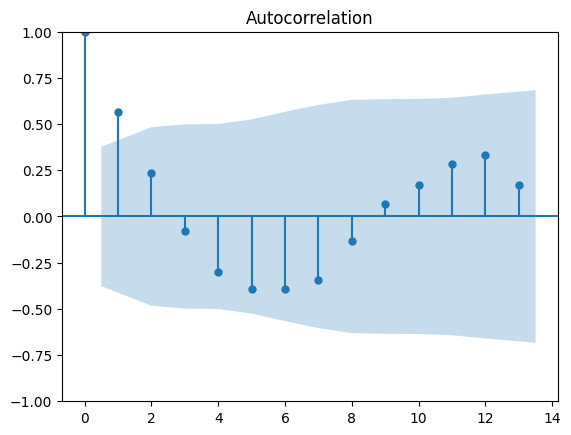

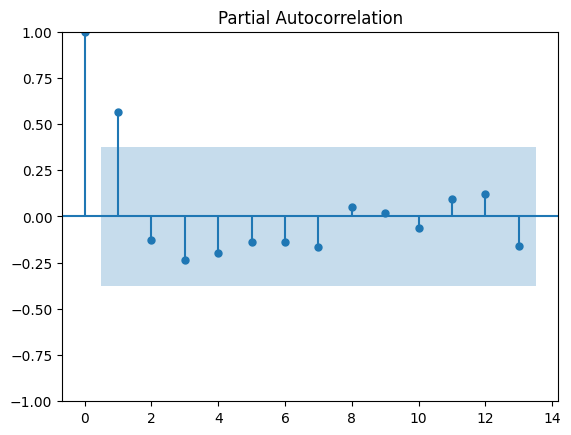

In [12]:
plot_acf(df['revenue'])
plot_pacf(df['revenue'])
plt.show()

Pada SARIMA, kita punya dua “pasang” parameter ARIMA—non-musiman (p, d, q) dan musiman (P, D, Q, m). Setelah membuat data stasioner (differencing biasa dan/atau musiman), kita gunakan ACF dan PACF untuk memilih p, q, P, dan Q:

1. Non-musiman: p (AR) dan q (MA)
- p (Order AR non-musiman)

 - Lihat plot PACF (Partial Autocorrelation Function) pada data yang sudah distasioner (setelah differencing d kali).

 - Cari lag ke-k pertama yang masih signifikan (misalnya spike keluar dari batas confidence interval), kemudian setelah lag k spike-nya “berhenti” (cut-off).

 - Nilai k itu biasanya kita pilih sebagai p.

- q (Order MA non-musiman)

 - Lihat plot ACF (Autocorrelation Function) pada data stasioner.

 - Cari lag ke-k pertama yang signifikan dengan pola cut-off—setelah lag k korelasi langsung turun ke nol.

 - Nilai k adalah kandidat untuk q.

2. Musiman: P (AR musiman) dan Q (MA musiman)
Misalkan data Anda bulanan dengan periode musiman m = 12.

- P (Order AR musiman)

 - Lihat PACF pada lag-lag kelipatan m (12, 24, 36, …).

 - Kalau di lag 12 ada spike yang signifikan lalu setelahnya tidak ada spike di kelipatan 12 berikutnya, maka P = 1.

 - Kalau misalnya lag 12 dan lag 24 sama-sama signifikan, mungkin P = 2, dan seterusnya.

- Q (Order MA musiman)

 - Lihat ACF pada lag-lag kelipatan m.

 - Spike signifikan di lag 12 (cut-off setelahnya) → Q = 1. Spike di 12 & 24 → Q = 2, dst.



Berdasarkan grafik:

ACF:

- Lag 1 sangat tinggi, kemudian gradual decay hingga lag 6–8 (tanpa cut-off tiba-tiba) ⇒ indikasi AR non-musiman, bukan MA.

- Spike positif di lag 12 (cut-off setelahnya) ⇒ indikasi seasonal MA di Q.

PACF:

- Spike signifikan hanya di lag 1, lalu semua lag 2–11 masuk confidence band ⇒ p = 1, q non-musiman = 0.

- Tidak ada spike musiman (lag 12) di PACF ⇒ P = 0.

**Fit Model SARIMA**

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [23]:
model = SARIMAX(df['revenue'],
                order=(1, 0, 0),
                seasonal_order=(0, 0, 1, 12))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [24]:
result = model.fit(disp=False)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [25]:
print(result.summary())

                                      SARIMAX Results                                       
Dep. Variable:                              revenue   No. Observations:                   27
Model:             SARIMAX(1, 0, 0)x(0, 0, [1], 12)   Log Likelihood                -557.936
Date:                              Tue, 24 Jun 2025   AIC                           1121.871
Time:                                      17:44:33   BIC                           1125.759
Sample:                                  01-01-2023   HQIC                          1123.027
                                       - 03-01-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9733      0.057     17.093      0.000       0.862       1.085
ma.S.L12       0.40

- ar.L1 ≈ 0.97: model AR(1) non-musiman sangat kuat; hampir semua nilai diprediksi dari nilai bulan sebelumnya. Sangat signifikan (p≈0). Nilai sekarang sangat dipengaruhi oleh nilai periode lalu.

- ma.S.L12 ≈ 0.40: efek musiman (lag-12) kurang meyakinkan secara statistik. Tidak signifikan (p=0.511). Komponen seasonal MA(1) lemah/uncertain.

Tindak Lanjut
- Model AR(1) non-musiman bekerja sangat baik (ar.L1 signifikan, residual bersih).
- Komponen seasonal MA(1) kurang kuat; Anda bisa coba Q=0 atau cobalah model lain (contoh SARIMA(1,0,0)(0,0,0,12) atau ARIMA(1,0,0)).
- Dengan data terbatas (27 titik), pertimbangkan mengurangi kompleksitas seasonal atau menambah lebih banyak data sebelum menguatkan komponen musiman.

Coba model SARIMA(1,0,0)(0,0,0,12) alias ARIMA (1,0,0)

In [26]:
model = SARIMAX(df['revenue'],
                order=(1, 0, 0),
                seasonal_order=(0, 0, 0, 12))

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [27]:
result = model.fit(disp=False)

In [28]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                revenue   No. Observations:                   27
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -559.174
Date:                Tue, 24 Jun 2025   AIC                           1122.347
Time:                        17:52:29   BIC                           1124.939
Sample:                    01-01-2023   HQIC                          1123.118
                         - 03-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9838      0.035     28.085      0.000       0.915       1.052
sigma2       4.99e+16   4.07e-21   1.23e+37      0.000    4.99e+16    4.99e+16
Ljung-Box (L1) (Q):                   0.66   Jarque-

Diagnostics

Ljung-Box Q (L1) p=0.41 → residual acak, tak ada autokorelasi tersisa.

Jarque–Bera p=0.85 → residual mendekati normal.

Heteroskedastisitas p=0.22 → varians residual stabil.

Kesimpulan:
- Model dengan seasonal MA(1) (Q=1) memiliki AIC sedikit lebih rendah (1121.87 vs 1122.35), meski komponen seasonal itu secara statistik tidak signifikan.
- Pilih model sederhana (AR(1) saja) bila Anda butuh parsimoni—perbedaan AIC minimal, residual sama‐sama “bersih”.

**Revenue Forecast 1 Bulan Kedepan**

In [29]:
forecast = result.get_forecast(steps=1)

In [32]:
# Ambil nilai prediksi dan interval kepercayaannya
pred_mean = forecast.predicted_mean.iloc[0]
conf_int  = forecast.conf_int().iloc[0]

# predicted_mean adalah nilai yang diprediksi untuk bulan berikutnya
# conf_int() mengembalikan interval kepercayaan (default 95%) untuk estimasi tersebut.

In [33]:
print(f"Forecast 1 bulan ke depan: {pred_mean:.2f}")
print("95% confidence interval:")
print(f"  Lower bound: {conf_int[0]:.2f}")
print(f"  Upper bound: {conf_int[1]:.2f}")

Forecast 1 bulan ke depan: 1070978284.40
95% confidence interval:
  Lower bound: 633172350.72
  Upper bound: 1508784218.07


/tmp/ipython-input-33-2508864033.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"  Lower bound: {conf_int[0]:.2f}")
/tmp/ipython-input-33-2508864033.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"  Upper bound: {conf_int[1]:.2f}")


/tmp/ipython-input-34-108745154.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'lower_ci': [conf_int[0]],
/tmp/ipython-input-34-108745154.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'upper_ci': [conf_int[1]]


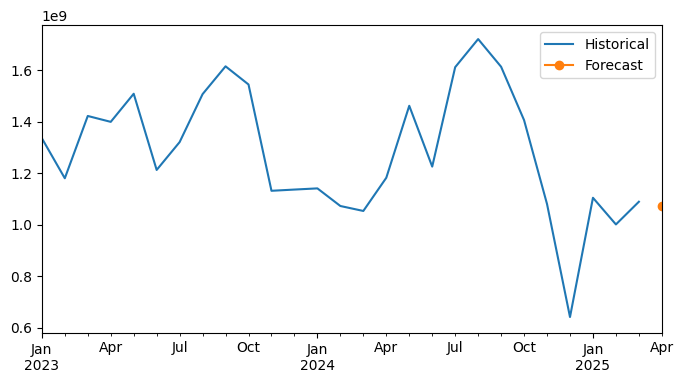

In [34]:
# Buat tanggal untuk forecasting
last_date = df.index[-1]
next_date = last_date + pd.DateOffset(months=1)

# Masukkan ke DataFrame
df_forecast = pd.DataFrame({
    'forecast': [pred_mean],
    'lower_ci': [conf_int[0]],
    'upper_ci': [conf_int[1]]
}, index=[next_date])

# Gabungkan dengan data historis untuk plotting
df_all = pd.concat([df[['revenue']], df_forecast], axis=0)

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
df_all['revenue'].plot(label='Historical')
df_all['forecast'].plot(label='Forecast', marker='o')
plt.fill_between(df_forecast.index,
                 df_forecast['lower_ci'],
                 df_forecast['upper_ci'],
                 alpha=0.3)
plt.legend()
plt.show()